# MVC project: exploration

## Todos

# 1. Import data

In [1]:
import mvc  # local functions (see mvc/ folder)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="ticks")

In [2]:
data_path = '/media/romain/E/Projet_MVC/data/Final_output'
mat = mvc.fileio.ImportMat(data_path)

project 'Sylvain_2015' loaded (10 participants)
project 'Landry_2013' loaded (21 participants)
project 'Landry_2012' loaded (18 participants)
project 'Landry_2015_2' loaded (11 participants)
project 'Yoann_2015' loaded (22 participants)
project 'Landry_2015_1' loaded (14 participants)
project 'Patrick_2013' loaded (16 participants)
	total participants: 112


## Dimensions description

- `mat.data['Landry_2012']` contains the data with three dimensions:
$\text{participant}(n) \times \text{muscle}(12) \times \text{test}(15)$

In [3]:
# 3d matrix to lists
participants, datasets, muscles, tests, relative_mvc = ([] for i in range(5))

for idataset in list(mat.data.keys()):
    for iparticipant in range(mat.data[idataset].shape[0]):
        for imuscle in range(mat.data[idataset].shape[1]):
            max_mvc = np.nanmax(mat.data[idataset][iparticipant, imuscle, :])
            for itest in range(mat.data[idataset].shape[2]):
                participants.append(iparticipant+1)
                datasets.append(idataset)
                muscles.append(imuscle+1)
                tests.append(itest+1)
                # normalize mvc (relative to max)
                relative_mvc.append(mat.data[idataset][iparticipant, imuscle, itest]*100/max_mvc)

/home/romain/miniconda3/envs/mvc/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: All-NaN slice encountered


In [4]:
# lists to single dataframe
df = pd.DataFrame({
    'participant': participants,
    'dataset': datasets,
    'muscle': muscles,
    'test': tests,
    'relative_mvc': relative_mvc,
}).dropna()

df.head()

,dataset,muscle,participant,relative_mvc,test
0,Sylvain_2015,1,1,100.000000,1
1,Sylvain_2015,1,1,69.322225,2
2,Sylvain_2015,1,1,84.917656,3
3,Sylvain_2015,1,1,80.983069,4
4,Sylvain_2015,1,1,65.163384,5


## Data description

In [5]:
def table_count(d, values, index, columns):
    table = d.pivot_table(values, index, columns,
                          aggfunc=lambda x: len(x)/x.nunique(),
                          fill_value=0).astype(int)
    #table.loc['total'] = table.sum(axis=0)
    #table['n'] = (table != 0).astype(int).sum(axis=1)
    n = table.sum(axis=0)
    total = (table != 0).astype(int).sum(axis=1)
    fig, ax = plt.subplots(figsize=(15, 8))
    sns.heatmap(table, annot=True, fmt="d", linewidths=.5, cmap="PuBu", ax=ax)
    plt.show()
    return table, n, total

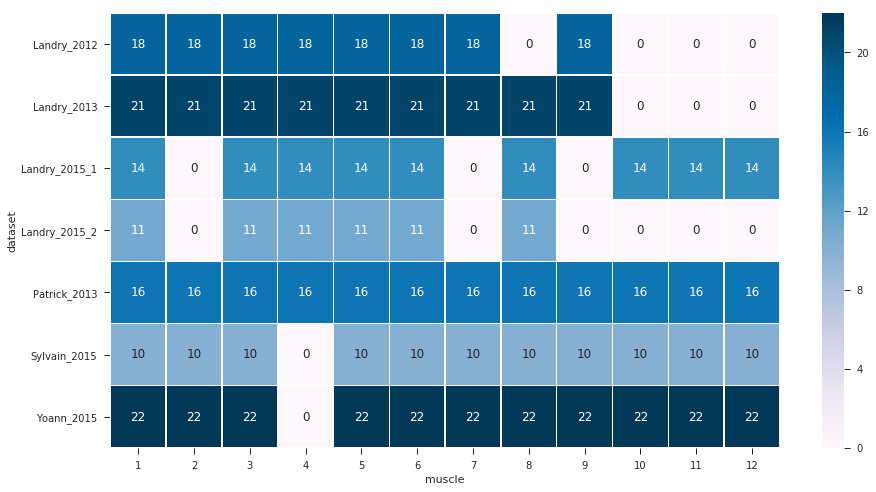

In [6]:
# pivot table: muscle count
table_muscle, _, total = table_count(df, values='test', index='dataset', columns='muscle')

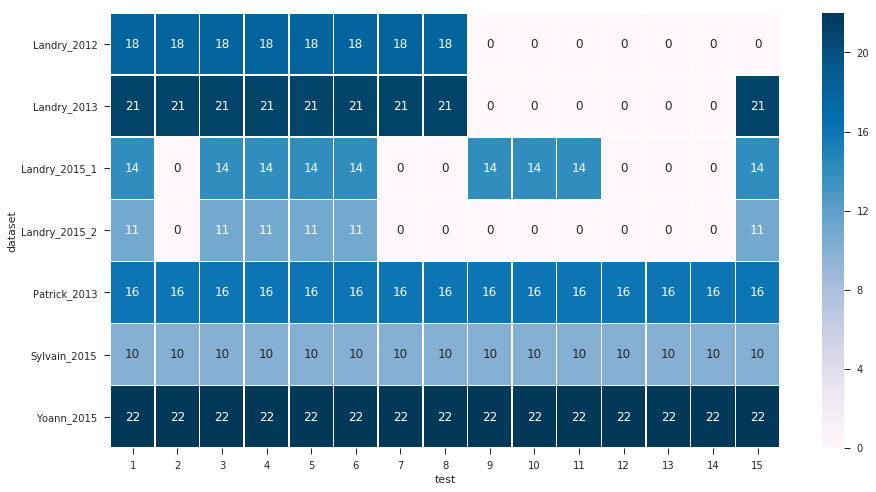

In [7]:
# pivot table: test count
table_test, n, _ = table_count(df, values='muscle', index='dataset', columns='test')

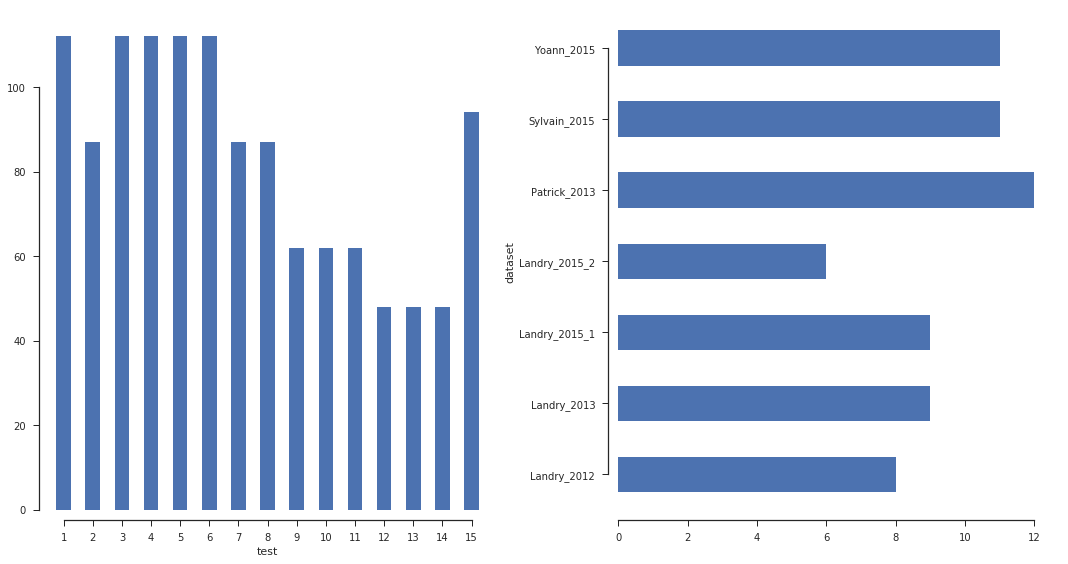

In [8]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))
n.plot(kind='bar',ax=ax1)
total.plot(kind='barh',ax=ax2)
sns.despine(offset=10, trim=True)
fig.tight_layout()
plt.show()

- Muscles `10`, `11` and `12`  (_intras_) have only $62$ mvc
- Muscles `1`, `3`, `5` and `6` have $112$ mvc
---
- The following datasets have performed the $15$ tests: `Yoann_2015`, `Sylvain_2015` and `Patrick_2013`
- `Landry_2015_2` have only $6$ tests and `Landry_2012` $8$

# 2. Datasets Homogeneity

In [9]:
#func = lambda x: 100*x.count()/df.shape[0]
max = df[df['relative_mvc'] == 100].pivot_table(values='muscle', index='dataset', columns='test',
                                                aggfunc='count', fill_value=0)
max = (max.div(max.sum(axis=1), axis=0)*100).astype(int)

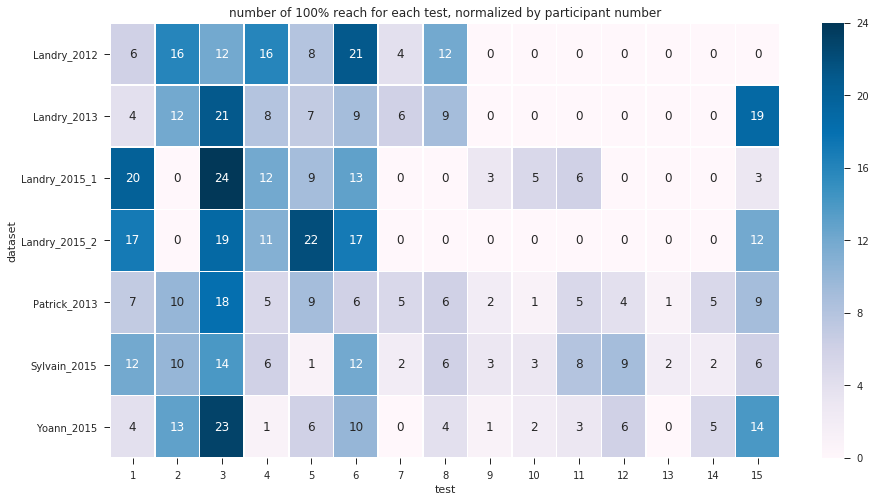

In [10]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(max, annot=True, fmt="d", linewidths=.5, ax=ax, cmap='PuBu')
ax.set_title('number of 100% reach for each test, normalized by participant number')
plt.show()

# Save dataframe to HDF5 file

In [12]:
store = pd.HDFStore('MVC.h5', 'w')
store['MVC'] = df
store.close()